<a href="https://colab.research.google.com/github/Krystian3000/nft_price_prediciton/blob/main/xgboost_baseline_vol1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**As we are in process of gathering the data, this notebook is to be seen only as a template for further experiments!**

# Istall and import required packages

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error #mape error for one of our metrics + metrics for comparison between models
from sklearn.model_selection import TimeSeriesSplit
import wandb
from google.colab import userdata
from google.cloud import bigquery
import os
from pathlib import Path
import requests
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
response = requests.get(f"https://raw.githubusercontent.com/Krystian3000/frontend/main/panelApps/nft-engineering-diploma-c933de618c2e.json?token=GHSAT0AAAAAACEDDV2HACZPSSQJIRAGWKXEZKKS3LQ", headers = {'Authorization': f'token {userdata.get("github_token")}'})

if response.status_code == 200:
    # If the request is successful, save the file locally
    with open("bigquery_secret.json", 'wb') as file:
        file.write(response.content)
    print("Successfully saved file")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


Successfully saved file


In [4]:
#File with credentials must be copied into cwd for the time being -- to be automated;stored in gcp secrets
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.join(Path(os.getcwd()).resolve(), "bigquery_secret.json")

In [5]:
# Initialize W&B with your API key
wandb.login(key=userdata.get("wandb_api_key"))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Import data

In [6]:
def execute_query(query):
    # Create a BigQuery client
    client = bigquery.Client()

    # Create a context manager to ensure the connection is properly closed
    with client as bq_client:
        # Run the query
        query_job = bq_client.query(query)
        # Wait for the query to complete
        df = query_job.to_dataframe()

    client.close()
    del client

    return df

In [7]:
query = f"SELECT date_time, active_floor_price FROM `nft-engineering-diploma.opensea.active_listings_1m_aggregate` ORDER BY date_time"
df_raw = execute_query(query)

In [11]:
df = df_raw.rename(columns={'active_floor_price':'price'}).astype({"price":np.float16}).set_index('date_time').copy() #deepcopy to avoid inference
df

,price
date_time,
2017-06-24 00:04:00+00:00,0.300049
2017-06-24 00:05:00+00:00,0.300049
2017-06-24 00:06:00+00:00,0.300049
2017-06-24 00:07:00+00:00,0.300049
2017-06-24 00:08:00+00:00,0.300049
...,...
2017-07-23 23:56:00+00:00,0.209961
2017-07-23 23:57:00+00:00,0.209961
2017-07-23 23:58:00+00:00,0.209961


In [13]:
df.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43197 entries, 0 to 43196
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date_time  43197 non-null  datetime64[ns, UTC]
 1   price      43197 non-null  float16            
dtypes: datetime64[ns, UTC](1), float16(1)
memory usage: 422.0 KB


<Axes: title={'center': 'Price over time'}, xlabel='date_time'>

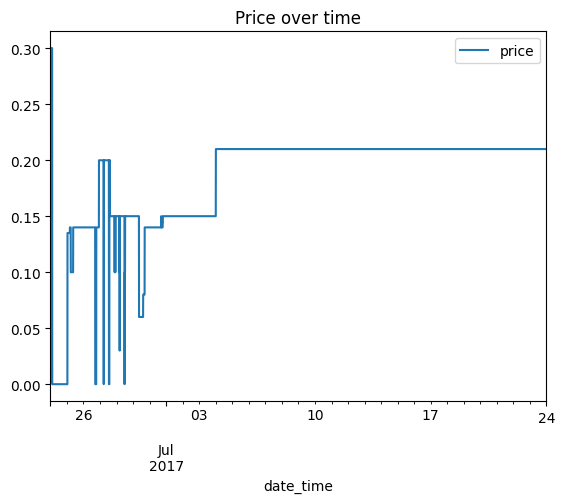

In [10]:
df.plot(title='Price over time')

# Create features

In [34]:
def create_ts_features(df):
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  return df

In [36]:
df = create_ts_features(df)

# Features / Target relationship

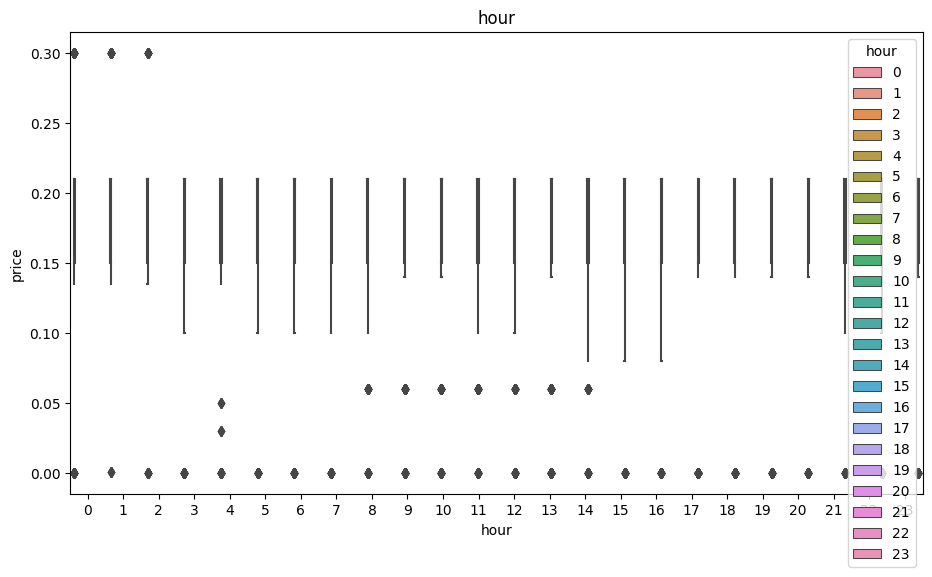

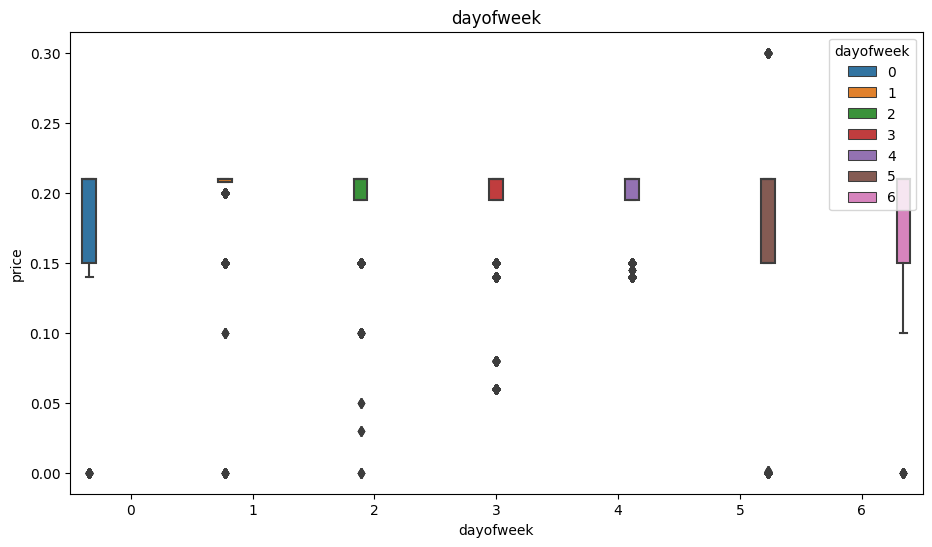

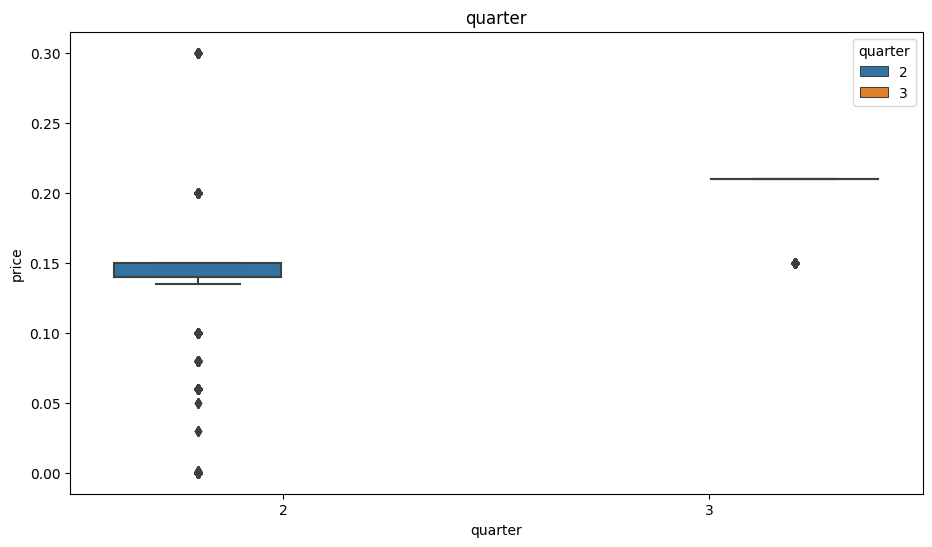

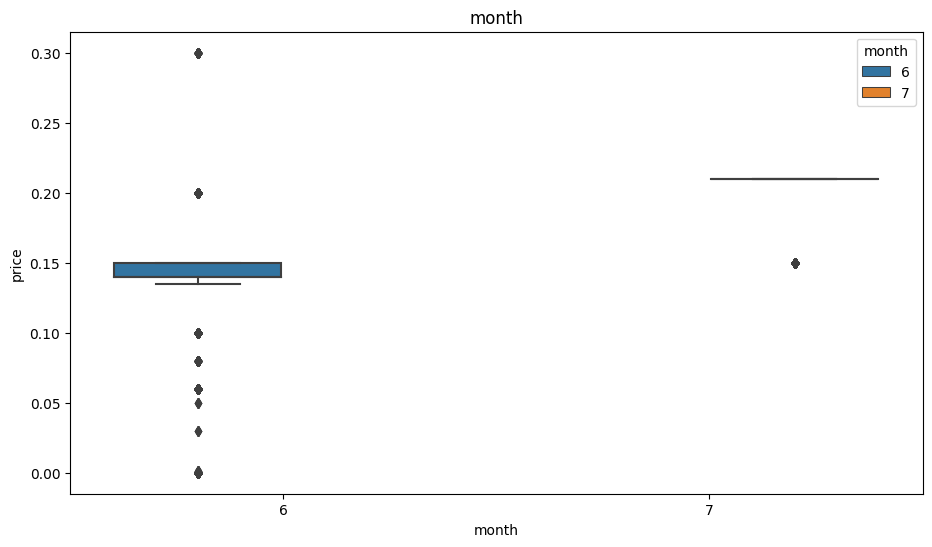

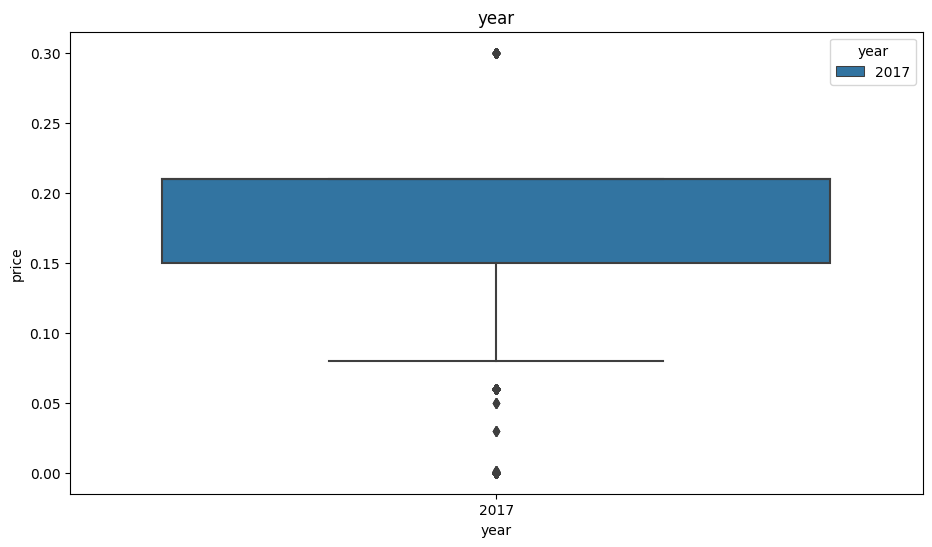

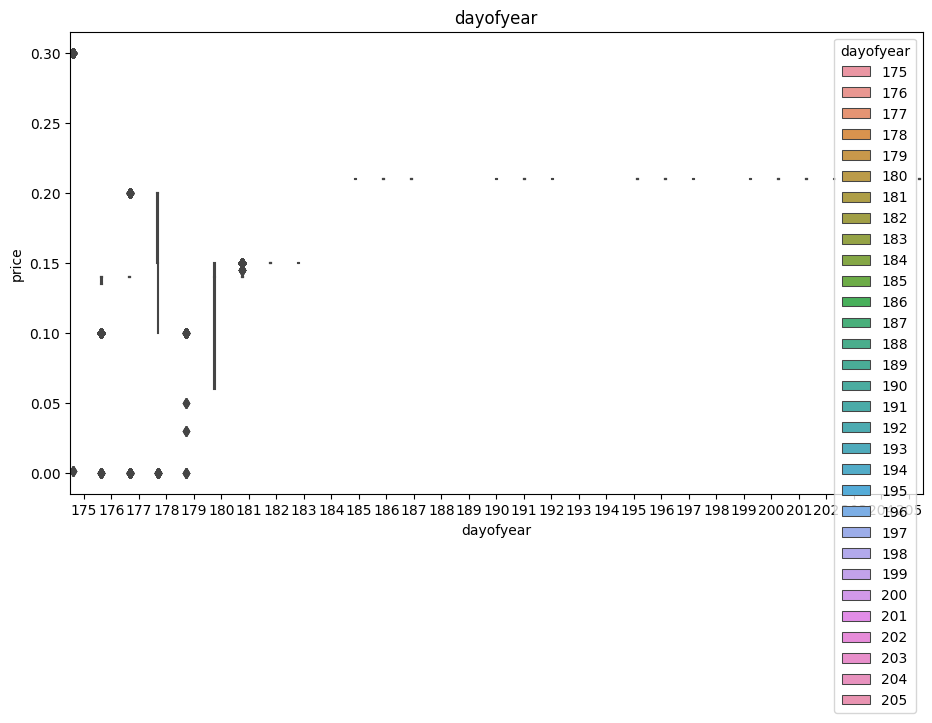

In [38]:
for col in df.columns:
  if col != 'price':
    fig, ax = plt.subplots(figsize=(11,6))
    sns.boxplot(x=col, y='price', data=df, hue=col, ax=ax)
    plt.title(col)
    plt.show()

## Train/test split

In [39]:
split_ratio = 0.8
split_index = df.index[int(len(df)*split_ratio)]

In [43]:
train = df.loc[df.index < split_index].copy()
test = df.loc[df.index >= split_index].copy()

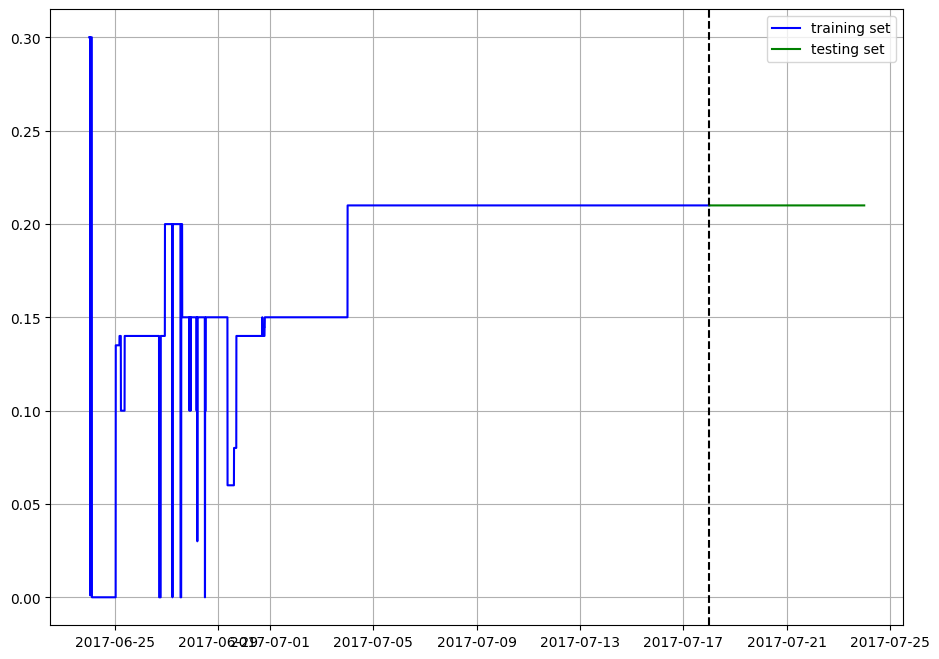

In [44]:
fig, ax = plt.subplots(figsize=(11,8))
ax.plot(train['price'], color='blue', label='training set')
ax.plot(test['price'], color='green', label='testing set')
ax.axvline(split_index, color='black', ls='--')
plt.legend()
plt.grid()
plt.show()

# Model

In [46]:
X_train = train.loc[:, train.drop(columns=['price']).columns]
y_train = train.loc[:, 'price']

In [48]:
X_test = test.loc[:, test.drop(columns=['price']).columns]
y_test = test.loc[:, 'price']

In [50]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.1)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
         verbose=True)

[0]	validation_0-rmse:0.04632	validation_1-rmse:0.02910
[1]	validation_0-rmse:0.04220	validation_1-rmse:0.02619
[2]	validation_0-rmse:0.03853	validation_1-rmse:0.02357
[3]	validation_0-rmse:0.03522	validation_1-rmse:0.02121
[4]	validation_0-rmse:0.03216	validation_1-rmse:0.01909
[5]	validation_0-rmse:0.02957	validation_1-rmse:0.01718
[6]	validation_0-rmse:0.02715	validation_1-rmse:0.01546
[7]	validation_0-rmse:0.02503	validation_1-rmse:0.01392
[8]	validation_0-rmse:0.02326	validation_1-rmse:0.01253
[9]	validation_0-rmse:0.02161	validation_1-rmse:0.01127
[10]	validation_0-rmse:0.02024	validation_1-rmse:0.01015
[11]	validation_0-rmse:0.01908	validation_1-rmse:0.00913
[12]	validation_0-rmse:0.01797	validation_1-rmse:0.00822
[13]	validation_0-rmse:0.01711	validation_1-rmse:0.00740
[14]	validation_0-rmse:0.01626	validation_1-rmse:0.00666
[15]	validation_0-rmse:0.01553	validation_1-rmse:0.00599
[16]	validation_0-rmse:0.01499	validation_1-rmse:0.00539
[17]	validation_0-rmse:0.01454	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature importance

<Axes: title={'center': 'Feature importance'}, ylabel='feature'>

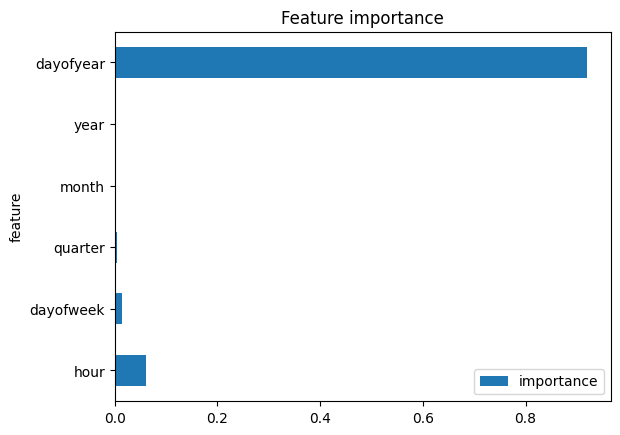

In [61]:
pd.DataFrame({'feature':df.drop(columns=['price']).columns, 'importance':reg.feature_importances_}).set_index('feature').plot(kind='barh', title='Feature importance')

# Forecast on test

In [68]:
pred = reg.predict(X_test)
test['prediction'] = pred

In [70]:
!pip install ipympl
%matplotlib widget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.2 MB/s eta 0:00:00


In [72]:
from google.colab import output
output.enable_custom_widget_manager()

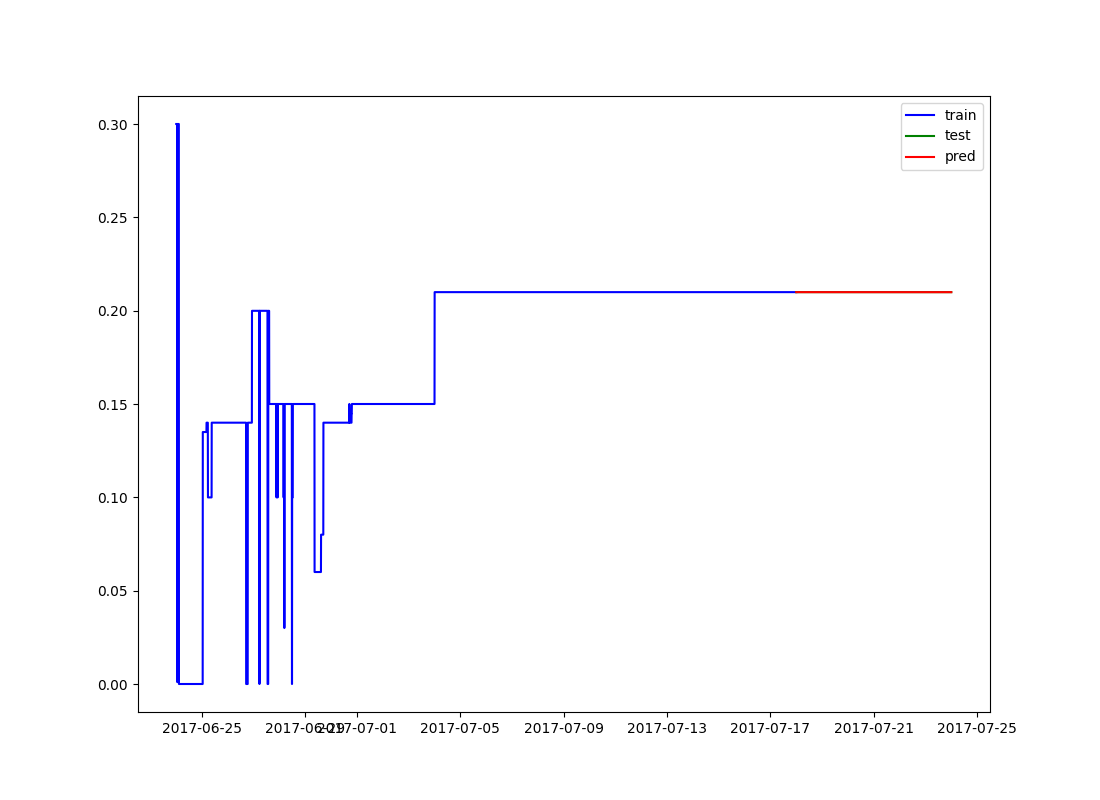

In [73]:
fig, ax = plt.subplots(figsize=(11,8))
plt.plot(train['price'], color='blue', label='train')
plt.plot(test['price'], color='green', label='test')
plt.plot(test['prediction'], color='red', label='pred')
plt.legend()
plt.show()